In [ ]:
#|default_exp data.validation

# Spliting data

In [ ]:
#|export
from tsai.imports import *
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from fastcore.xtras import is_listy
from tsai.utils import *

In [ ]:
#|export
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(list(torch.randperm(len(o)).numpy()))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner

In [ ]:
#|export
def check_overlap(a, b, c=None):
    "Checks if there's overlap between array-like objects"
    a = np.asarray(a).flatten()
    b = np.asarray(b).flatten()
    c = np.asarray(c).flatten() if c is not None else c
    ab = np.isin(a, b)
    ac = np.isin(a, c) if c is not None else np.array([False])
    bc = np.isin(b, c) if c is not None else np.array([False])
    if ab.sum() + ac.sum() + bc.sum() == 0: return False
    if c is None: return L(a[ab].tolist())
    return L(a[ab].tolist()), L(a[ac].tolist()), L(b[bc].tolist())

def check_splits_overlap(splits):
    return [check_overlap(*_splits) for _splits in splits] if is_listy(splits[0][0]) else check_overlap(*splits)

def leakage_finder(*splits, verbose=True):
    '''You can pass splits as a tuple, or train, valid, ...'''
    splits = L(*splits)
    overlaps = 0
    for i in range(len(splits)):
        for j in range(i + 1, len(splits)):
            overlap = check_overlap(splits[i], splits[j])
            if overlap: 
                pv(f'overlap between splits [{i}, {j}] {overlap}', verbose)
                overlaps += 1
    assert overlaps == 0, 'Please, review your splits!'

def balance_idx(o, shuffle=False, strategy="oversample", random_state=None, verbose=False):
    assert strategy in ["oversample", "undersample"]
    if isinstance(o, list): o = L(o)
    idx_ = np.arange(len(o)).reshape(-1, 1)
    if strategy == "oversample":
        ros = RandomOverSampler(random_state=random_state)
    elif strategy == "undersample":
        ros = RandomUnderSampler(random_state=random_state)
    resampled_idxs, _ = ros.fit_resample(idx_, np.asarray(o))
    new_idx = L(resampled_idxs.reshape(-1,).tolist())
    if shuffle: new_idx = random_shuffle(new_idx)
    return new_idx

In [ ]:
a = np.arange(10)
b = np.arange(10, 20)
test_eq(check_overlap(a, b), False)
a = np.arange(10)
b = np.arange(9, 20)
test_eq(check_overlap(a, b), [9])
a = np.arange(10)
b = np.arange(10, 20)
c = np.arange(20, 30)
test_eq(check_overlap(a, b, c), False)
a = np.arange(10)
b = np.arange(10, 20)
c = np.arange(10, 30)
test_eq(check_overlap(a, b, c), ([], [], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]))

In [ ]:
y = np.concatenate([[i] * np.random.randint(10, 100) for i in range(5)])
train_split = np.random.choice(len(y), int(len(y) * .8), False)
c, v = np.unique(y[train_split], return_counts=True)
print(f"{'imbalanced:':25} {c} {v}")

oversampled_train_split = train_split[balance_idx(y[train_split], strategy="oversample")]
osc, osv = np.unique(y[oversampled_train_split], return_counts=True)
print(f"{'balanced (oversample):':25} {osc} {osv}")
test_eq(osv, [max(v)] * len(v))

undersampled_train_split = train_split[balance_idx(y[train_split], strategy="undersample")]
usc, usv = np.unique(y[undersampled_train_split], return_counts=True)
print(f"{'balanced (undersample):':25} {usc} {usv}")
test_eq(usv, [min(v)] * len(v))

imbalanced:               [0 1 2 3 4] [65 58 17 72 72]
balanced (oversample):    [0 1 2 3 4] [72 72 72 72 72]
balanced (undersample):   [0 1 2 3 4] [17 17 17 17 17]


In [ ]:
l = L(list(concat(np.zeros(5), np.ones(10)).astype(int)))
balanced_idx = balance_idx(l)
test_eq(np.mean(l[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

l = list(concat(np.zeros(5), np.ones(10)).astype(int))
balanced_idx = balance_idx(l)
test_eq(np.mean(L(l)[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

a = concat(np.zeros(5), np.ones(10)).astype(int)
balanced_idx = balance_idx(a)
test_eq(np.mean(a[balanced_idx]), 0.5)
test_eq(isinstance(balanced_idx, L), True)

t = concat(torch.zeros(5), torch.ones(10))
balanced_idx = balance_idx(t, shuffle=True)
test_eq(t[balanced_idx].mean(), 0.5)
test_eq(isinstance(balanced_idx, L), True)

In [ ]:
a, b = np.arange(100_000), np.arange(100_000, 200_000)

In [ ]:
soft_labels = True
filter_pseudolabels = .5
balanced_pseudolabels = True

pseudolabels = torch.rand(1000, 3)
pseudolabels = torch.softmax(pseudolabels, -1) if soft_labels else torch.argmax(pseudolabels, -1)
hpl = torch.argmax(pseudolabels, -1) if soft_labels else pseudolabels

if filter_pseudolabels and pseudolabels.ndim > 1: 
    error = 1 - pseudolabels.max(-1).values
    filt_pl_idx = np.arange(len(error))[error < filter_pseudolabels]
    filt_pl = pseudolabels[error < filter_pseudolabels]
    assert len(filt_pl) > 0, 'no filtered pseudolabels'
    filt_hpl = torch.argmax(filt_pl, -1)
else: 
    filt_pl_idx = np.arange(len(pseudolabels))
    filt_pl = filt_hpl = pseudolabels

In [ ]:
pl_split = filt_pl_idx[balance_idx(filt_hpl)] if balanced_pseudolabels else filt_pl_idx
test_eq(hpl[pl_split].float().mean(), np.mean(np.unique(hpl)))

In [ ]:
#|export
def TrainValidTestSplitter(n_splits:int=1, valid_size:Union[float, int]=0.2, test_size:Union[float, int]=0., train_only:bool=False,
                           stratify:bool=True, balance:bool=False, strategy:str="oversample", shuffle:bool=True, 
                           random_state:Union[None, int]=None, verbose:bool=False, **kwargs):
    "Split `items` into random train, valid (and test optional) subsets."
    
    if not shuffle and stratify and not train_only: 
        pv('stratify set to False because shuffle=False. If you want to stratify set shuffle=True', verbose)
        stratify = False
        
    def _inner(o, **kwargs):
        if stratify:
            _, unique_counts = np.unique(o, return_counts=True)
            if np.min(unique_counts) >= 2 and np.min(unique_counts) >= n_splits: stratify_ = stratify  
            elif np.min(unique_counts) < n_splits: 
                stratify_ = False
                pv(f'stratify set to False as n_splits={n_splits} cannot be greater than the min number of members in each class ({np.min(unique_counts)}).', 
                   verbose)
            else:
                stratify_ = False
                pv('stratify set to False as the least populated class in o has only 1 member, which is too few.', verbose)
        else: stratify_ = False
        vs = 0 if train_only else 1. / n_splits if n_splits > 1 else int(valid_size * len(o)) if isinstance(valid_size, float) else valid_size
        if test_size: 
            ts = int(test_size * len(o)) if isinstance(test_size, float) else test_size
            train_valid, test = train_test_split(range(len(o)), test_size=ts, stratify=o if stratify_ else None, shuffle=shuffle, 
                                                 random_state=random_state, **kwargs)
            test = toL(test)
            if shuffle: test = random_shuffle(test, random_state)
            if vs == 0:
                train, _ = RandomSplitter(0, seed=random_state)(o[train_valid])
                train = toL(train)
                if balance: train = train[balance_idx(o[train], random_state=random_state, strategy=strategy)]
                if shuffle: train = random_shuffle(train, random_state)
                train_ = L(L([train]) * n_splits) if n_splits > 1 else train
                valid_ = L(L([train]) * n_splits) if n_splits > 1 else train
                test_ = L(L([test]) * n_splits) if n_splits > 1 else test
                if n_splits > 1: 
                    return [split for split in itemify(train_, valid_, test_)]
                else: 
                    return train_, valid_, test_
            elif n_splits > 1: 
                if stratify_: 
                    splits = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(train_valid)), o[train_valid])
                else:
                    splits = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(train_valid)))
                train_, valid_ = L([]), L([])
                for train, valid in splits:
                    train, valid = toL(train), toL(valid)
                    if balance: train = train[balance_idx(o[train], random_state=random_state, strategy=strategy)]
                    if shuffle: 
                        train = random_shuffle(train, random_state)
                        valid = random_shuffle(valid, random_state)
                    train_.append(L(L(train_valid)[train]))
                    valid_.append(L(L(train_valid)[valid]))
                test_ = L(L([test]) * n_splits)
                return [split for split in itemify(train_, valid_, test_)]
            else:
                train, valid = train_test_split(range(len(train_valid)), test_size=vs, random_state=random_state, 
                                                stratify=o[train_valid] if stratify_ else None, shuffle=shuffle, **kwargs)
                train, valid = toL(train), toL(valid)
                if balance: train = train[balance_idx(o[train], random_state=random_state, strategy=strategy)]
                if shuffle: 
                    train = random_shuffle(train, random_state)
                    valid = random_shuffle(valid, random_state)
                return (L(L(train_valid)[train]), L(L(train_valid)[valid]),  test)
        else: 
            if vs == 0:
                train, _ = RandomSplitter(0, seed=random_state)(o)
                train = toL(train)
                if balance: train = train[balance_idx(o[train], random_state=random_state, strategy=strategy)]
                if shuffle: train = random_shuffle(train, random_state)
                train_ = L(L([train]) * n_splits) if n_splits > 1 else train
                valid_ = L(L([train]) * n_splits) if n_splits > 1 else train
                if n_splits > 1: 
                    return [split for split in itemify(train_, valid_)]
                else: 
                    return (train_, valid_)
            elif n_splits > 1: 
                if stratify_: splits = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(o)), o)
                else: splits = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state).split(np.arange(len(o)))
                train_, valid_ = L([]), L([])
                for train, valid in splits:
                    train, valid = toL(train), toL(valid)
                    if balance: train = train[balance_idx(o[train], random_state=random_state, strategy=strategy)]
                    if shuffle: 
                        train = random_shuffle(train, random_state)
                        valid = random_shuffle(valid, random_state)
                    if not isinstance(train, (list, L)):  train = train.tolist()
                    if not isinstance(valid, (list, L)):  valid = valid.tolist()
                    train_.append(L(train))
                    valid_.append(L(L(valid)))
                return [split for split in itemify(train_, valid_)]
            else:
                train, valid = train_test_split(range(len(o)), test_size=vs, random_state=random_state, stratify=o if stratify_ else None, 
                                                shuffle=shuffle, **kwargs)
                train, valid = toL(train), toL(valid)
                if balance: train = train[balance_idx(o[train], random_state=random_state, strategy=strategy)]
                return train, valid
    return _inner

In [ ]:
#|export
def plot_splits(splits):
    _max = 0
    _splits = 0
    for i, split in enumerate(splits):
        if is_listy(split[0]):
            for j, s in enumerate(split):
                _max = max(_max, array(s).max())
                _splits += 1
        else: 
            _max = max(_max, array(split).max())
            _splits += 1
    _splits = [splits] if not is_listy(split[0]) else splits
    v = np.zeros((len(_splits), _max + 1))
    for i, split in enumerate(_splits):
        if is_listy(split[0]):
            for j, s in enumerate(split): 
                v[i, s] = 1 + j
        else: v[i, split] = 1 + i
    vals = np.unique(v)
    if 2 in vals and 3 not in vals:
        vals = [v + 1 if v == 2 else v for v in vals]
    plt.figure(figsize=(16, len(_splits)/2))
    if len(vals) == 1:
        v = np.ones((len(_splits), _max + 1))
        plt.pcolormesh(v, color='blue')
        legend_elements = [Patch(facecolor='blue', label='Train')]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    else: 
        colors = L(['gainsboro', 'blue', 'orange', 'limegreen'])[vals]
        cmap = LinearSegmentedColormap.from_list('', colors)
        plt.pcolormesh(v, cmap=cmap)
        legend_elements = L([
            Patch(facecolor='gainsboro', label='None'),
            Patch(facecolor='blue', label='Train'),
            Patch(facecolor='orange', label='Valid'),
            Patch(facecolor='limegreen', label='Test')])[vals]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Split distribution')
    plt.yticks(ticks=np.arange(.5, len(_splits)+.5, 1.0), labels=np.arange(1, len(_splits)+1, 1.0).astype(int))
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
#|export
def get_splits(o, n_splits:int=1, valid_size:float=0.2, test_size:float=0., train_only:bool=False, train_size:Union[None, float, int]=None, balance:bool=False,
               strategy:str="oversample", shuffle:bool=True, stratify:bool=True, check_splits:bool=True, random_state:Union[None, int]=None, 
               show_plot:bool=True, verbose:bool=False):
    '''Arguments: 
        o            : object to which splits will be applied, usually target.
        n_splits     : number of folds. Must be an int >= 1.
        valid_size   : size of validation set. Only used if n_splits = 1. If n_splits > 1 valid_size = (1. - test_size) / n_splits. 
        test_size    : size of test set. Default = 0.
        train_only   : if True valid set == train set. This may be useful for debugging purposes.
        train_size   : size of the train set used. Default = None (the remainder after assigning both valid and test). 
                        Useful for to get learning curves with different train sizes or get a small batch to debug a neural net.
        balance      : whether to balance data so that train always contain the same number of items per class.
        strategy     : strategy to balance data ("undersample" or "oversample"). Default = "oversample".
        shuffle      : whether to shuffle data before splitting into batches. Note that the samples within each split will be shuffle.
        stratify     : whether to create folds preserving the percentage of samples for each class.
        check_splits : whether to perform leakage and completion checks.
        random_state : when shuffle is True, random_state affects the ordering of the indices. Pass an int for reproducible output.
        show_plot    : plot the split distribution
    '''
    if n_splits == 1 and valid_size == 0. and  test_size == 0.: train_only = True
    if balance: stratify = True
    splits = TrainValidTestSplitter(n_splits, valid_size=valid_size, test_size=test_size, train_only=train_only, stratify=stratify, 
                                    balance=balance, strategy=strategy, shuffle=shuffle, random_state=random_state, verbose=verbose)(o)
    if check_splits:
        if train_only or (n_splits == 1 and valid_size == 0): print('valid == train')
        elif n_splits > 1: 
            for i in range(n_splits): 
                leakage_finder([*splits[i]], verbose=True)
                cum_len = 0
                for split in splits[i]: cum_len += len(split)
                if not balance: assert len(o) == cum_len, f'len(o)={len(o)} while cum_len={cum_len}'
        else: 
            leakage_finder([splits], verbose=True)
            cum_len = 0
            if not isinstance(splits[0], Integral):
                for split in splits: cum_len += len(split)
            else: cum_len += len(splits)
            if not balance: assert len(o) == cum_len, f'len(o)={len(o)} while cum_len={cum_len}'
    if train_size is not None and train_size != 1: # train_size=1 legacy
        if n_splits > 1:
            splits = list(splits)
            for i in range(n_splits): 
                splits[i] = list(splits[i])
                if isinstance(train_size, Integral):
                    n_train_samples = train_size  
                elif train_size > 0 and train_size < 1: 
                    n_train_samples = int(len(splits[i][0]) * train_size)
                splits[i][0] = L(random_choice(splits[i][0], n_train_samples, False).tolist())
                if train_only:
                    if valid_size != 0: splits[i][1] = splits[i][0]
                    if test_size != 0: splits[i][2] = splits[i][0]
                splits[i] = tuple(splits[i])
            splits = tuple(splits)
        else: 
            splits = list(splits)
            if isinstance(train_size, Integral):
                n_train_samples = train_size  
            elif train_size > 0 and train_size < 1: 
                n_train_samples = int(len(splits[0]) * train_size)
            splits[0] = L(random_choice(splits[0], n_train_samples, False).tolist())
            if train_only:
                if valid_size != 0: splits[1] = splits[0]
                if test_size != 0: splits[2] = splits[0]
            splits = tuple(splits)
    if show_plot: plot_splits(splits)
    return splits

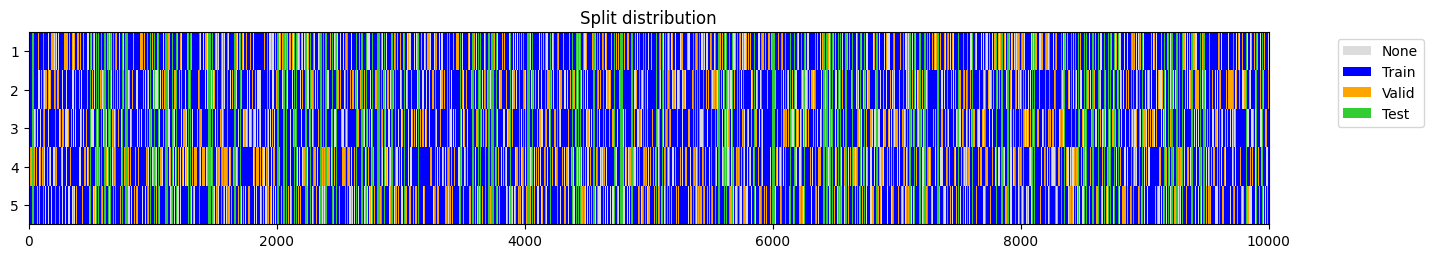

(((#5000) [1831,2914,3921,1429,4989,7747,4959,7494,2576,9060...],
  (#1600) [4159,1554,8525,5852,5670,3368,2112,9453,9910,5499...],
  (#2000) [7806,3235,373,8579,9844,594,5411,5341,4372,3711...]),
 ((#5000) [5527,9244,3643,3495,7725,9325,3983,2123,3149,80...],
  (#1600) [8971,9717,8245,2312,6256,3065,5466,9913,5232,7159...],
  (#2000) [7806,3235,373,8579,9844,594,5411,5341,4372,3711...]),
 ((#5000) [6834,5325,6822,4833,5963,6938,9803,9835,6878,288...],
  (#1600) [6332,2914,5353,3820,738,9086,3351,5785,7926,3460...],
  (#2000) [7806,3235,373,8579,9844,594,5411,5341,4372,3711...]),
 ((#5000) [7456,4171,1003,6638,1840,3693,561,8380,3111,6118...],
  (#1600) [7517,13,2935,8428,2783,7980,3938,9245,7358,6305...],
  (#2000) [7806,3235,373,8579,9844,594,5411,5341,4372,3711...]),
 ((#5000) [3634,697,6435,5431,7187,2231,2442,5717,9370,9669...],
  (#1600) [2016,7372,106,405,1319,8302,9551,3047,7255,1709...],
  (#2000) [7806,3235,373,8579,9844,594,5411,5341,4372,3711...]))

In [ ]:
n_splits                = 5
valid_size              = 0.2
test_size               = 0.2
train_only              = False  # set to True for debugging (valid = train)
train_size              = 5000
stratify                = True
balance                 = False
shuffle                 = True
predefined_splits       = None
show_plot               = True 


check_splits = True
random_state = 23

y = np.random.randint(0, 3, 10000) + 100

splits = get_splits(y, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                    train_only=train_only, train_size=train_size, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)
splits

valid == train


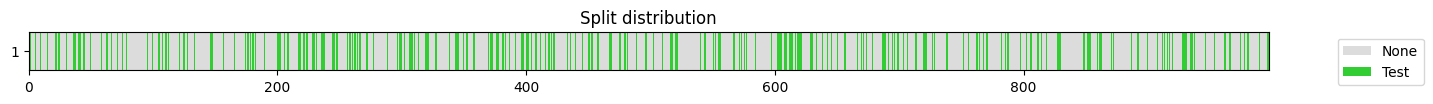

((#256) [604,296,256,112,22,44,656,638,698,891...],
 (#256) [604,296,256,112,22,44,656,638,698,891...])

In [ ]:
train_size=256
y = np.random.randint(0, 3, 1000) + 100
splits = get_splits(y, train_size=train_size, train_only=True)
test_eq(splits[0], splits[1])
test_eq(len(splits[0]), train_size)
splits

In [ ]:
#|export
def get_walk_forward_splits(
    o, # 3D object with shape [samples x features x steps] containing the time series we need to split
    n_splits=1, # # of splits
    train_size=None, # optional: training set size as an int or a float. None when using and anchored strategy.
    valid_size=0.2, # validation set size as an int or a float
    test_size=0., # test set size as an int or a float
    anchored = False, # starting point for train set remains the same for all splits
    gap = 0., # # of samples to exclude from the end of each train set before the validation set. Entered as an int or a float
    test_after_valid = True, # flag to indicate if validation and test will be samples randomly or sequentially
    random_state = None, # integer that can be used to generate reproducible results
    show_plot=True, # plots the splits created
):

    if anchored:
        train_size = None
    elif isinstance(train_size, float): 
        train_size = np.int32(np.floor(len(o) * train_size))
    if isinstance(valid_size, float): 
        valid_size = np.int32(np.floor(len(o) * valid_size))
    if isinstance(test_size, float): 
        test_size = np.int32(np.floor(len(o) * test_size))
    if isinstance(gap, float): 
        gap = np.int32(np.floor(len(o) * gap))

    if train_size is not None:
        assert train_size + (valid_size + test_size + gap) * n_splits <= len(o), "reduce train_size, valid_size, test_size, gap or n_splits"
    else:
        assert (valid_size + test_size + gap) * n_splits < len(o), "reduce valid_size, test_size, gap or n_splits"

    if not test_after_valid:
        assert valid_size == test_size

    train_idxs = []
    valid_idxs = []
    test_idxs = []

    end = 0
    all_idxs = np.arange(len(o))
    for n in range(n_splits):
        if valid_size > 0 and test_size > 0:
            if test_after_valid:
                test_idxs.append(L(all_idxs[-test_size:].tolist()))
                all_idxs = all_idxs[:-test_size]
                valid_idxs.append(L(all_idxs[-valid_size:].tolist()))
                all_idxs = all_idxs[:-valid_size]
                if gap > 0:
                    all_idxs = all_idxs[:-gap]
                if anchored:
                    train_idxs.append(L(all_idxs.tolist()))
                else:
                    train_idxs.append(L(all_idxs[-train_size:].tolist()))
            else:
                valid_test_idxs = all_idxs[-test_size - valid_size:]
                np.random.seed(random_state)
                valid_test_idxs = np.random.permutation(valid_test_idxs)
                valid_idxs.append(L(valid_test_idxs[:valid_size]))
                test_idxs.append(L(valid_test_idxs[valid_size:]))
                all_idxs = all_idxs[:-test_size - valid_size]
                if gap > 0:
                    all_idxs = all_idxs[:-gap]
                if anchored:
                    train_idxs.append(L(all_idxs.tolist()))
                else:
                    train_idxs.append(L(all_idxs[-train_size:].tolist()))
        elif valid_size > 0:
            valid_idxs.append(L(all_idxs[-valid_size:].tolist()))
            all_idxs = all_idxs[:-valid_size]
            test_idxs.append(L([]))
            if gap > 0:
                all_idxs = all_idxs[:-gap]
            if anchored:
                train_idxs.append(L(all_idxs.tolist()))
            else:
                train_idxs.append(L(all_idxs[-train_size:].tolist()))

    splits = []
    for n in range(n_splits):
        if valid_size > 0 and test_size > 0:
            splits.append((L(train_idxs[n]), L(valid_idxs[n]), L(test_idxs[n])))
        elif valid_size > 0:
            splits.append((L(train_idxs[n]), L(valid_idxs[n])))
        else:
            splits.append((L(train_idxs[n]),))
    splits = tuple(splits)[::-1]
    if show_plot:
        plot_splits(splits)
    return splits

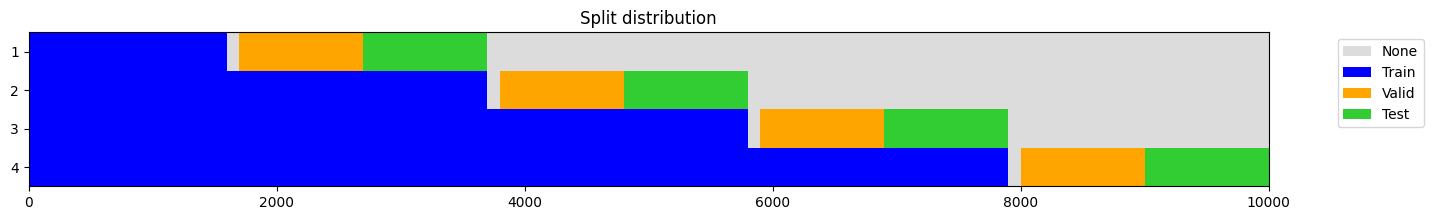

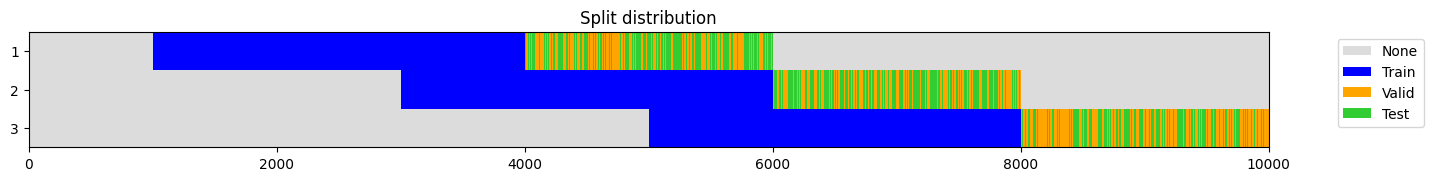

In [ ]:
o = np.random.rand(10_000, 3,  50) # shape: [samples x features x steps]

splits = get_walk_forward_splits(
    o, 
    n_splits=4, 
    train_size=.6,
    valid_size=0.1, 
    test_size=0.1, 
    anchored = True,
    gap = 100,
    test_after_valid = True,
    random_state = None,
    show_plot=True,
)

splits = get_walk_forward_splits(
    o, 
    n_splits=3, 
    train_size=0.3,
    valid_size=0.1, 
    test_size=0.1, 
    anchored = False,
    gap = 0.,
    test_after_valid = False,
    random_state = None,
    show_plot=True,
)

In [ ]:
#|export
def TSSplitter(
    valid_size=0.2, # int or float indicating the validation set size
    test_size=0., # int or float indicating the test set size
    fcst_horizon=0, # int that indicates the number of time steps removed at the end of train (and validation)
    show_plot=True, # flag that indicates if a plot showing the splits will be created
):
    "Create function that splits `items` between train/val with `valid_size` without shuffling data."
    
    if fcst_horizon: 
        fcst_horizon = fcst_horizon - 1
        
    def _inner(o):
        valid_cut = valid_size if isinstance(valid_size, Integral) else round(valid_size * len(o))
        if test_size: 
            test_cut = test_size if isinstance(test_size, Integral) else round(test_size * len(o))
        else:
            test_cut = 0
        idx = np.arange(len(o))
        if test_size: 
            splits = (L(idx[:-valid_cut - test_cut - fcst_horizon].tolist()), 
                      L(idx[-valid_cut - test_cut: - test_cut - fcst_horizon].tolist()),
                      L(idx[-test_cut:].tolist()))
        else: 
            splits = (L(idx[:-valid_cut - fcst_horizon].tolist()), L(idx[-valid_cut:].tolist()))
        if show_plot: 
            if len(o) > 1_000_000:
                warnings.warn('the splits are too large to be plotted')
            else: 
                plot_splits(splits) if test_size else plot_splits(splits[:2])
        return splits
    return _inner

TimeSplitter = TSSplitter

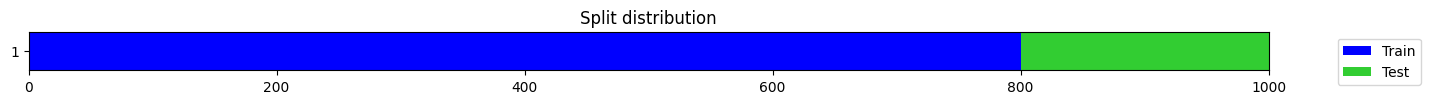

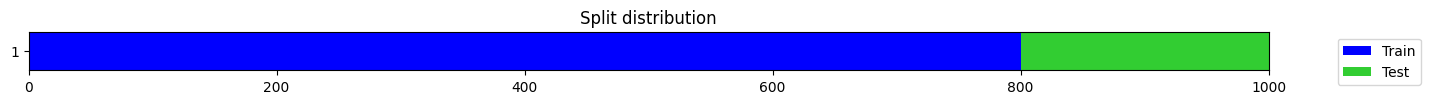

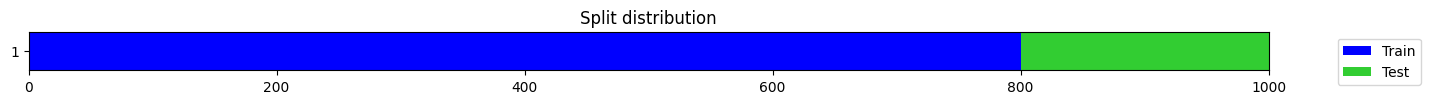

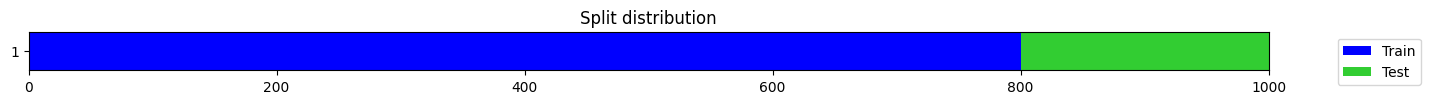

((#800) [0,1,2,3,4,5,6,7,8,9...],
 (#200) [800,801,802,803,804,805,806,807,808,809...])

In [ ]:
y = np.arange(1000) + 100
test_eq(TimeSplitter(valid_size=0.2)(y)[1], L(np.arange(800, 1000).tolist()))
test_eq(TimeSplitter(valid_size=0.2)(y)[0], TimeSplitter(valid_size=200)(y)[0])
TimeSplitter(valid_size=0.2, show_plot=True)(y)

stratify set to False as n_splits=5 cannot be greater than the min number of members in each class (1).


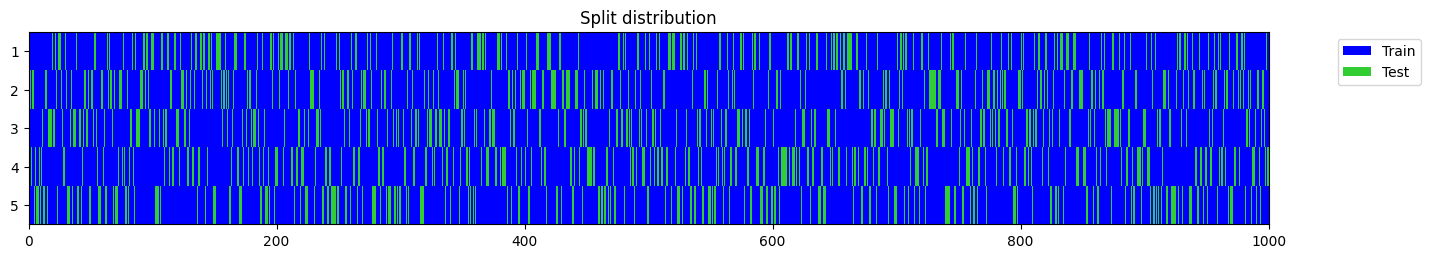

(601.11, (#800) [314,194,782,789,502,917,137,415,904,181...])

In [ ]:
n_splits                = 5
valid_size              = 0.2  
test_size               = 0
train_only              = False  # set to True for debugging (valid = train)
train_size              = None
stratify                = True
balance                 = True
shuffle                 = True
predefined_splits       = None
show_plot               = True 


check_splits = True
random_state = 23

splits = get_splits(y, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, balance=balance, stratify=stratify,
                    train_only=train_only, train_size=train_size, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)
split = splits[0] if n_splits == 1 else splits[0][0]
y[split].mean(), split

In [ ]:
list([splits[0], splits[1], splits[2], splits[3], splits[4]])

[((#800) [314,194,782,789,502,917,137,415,904,181...],
  (#200) [362,151,934,378,95,597,500,117,980,844...]),
 ((#800) [312,198,777,788,515,910,145,413,898,186...],
  (#200) [352,133,955,396,64,596,442,79,991,882...]),
 ((#800) [311,197,783,791,507,922,145,416,908,184...],
  (#200) [338,125,912,361,54,594,486,88,994,859...]),
 ((#800) [296,181,782,789,493,917,130,401,905,165...],
  (#200) [405,199,953,444,113,610,515,137,997,881...]),
 ((#800) [320,190,782,788,506,906,141,412,893,178...],
  (#200) [336,149,942,358,49,582,472,70,990,907...])]

stratify set to False as n_splits=5 cannot be greater than the min number of members in each class (1).
valid == train


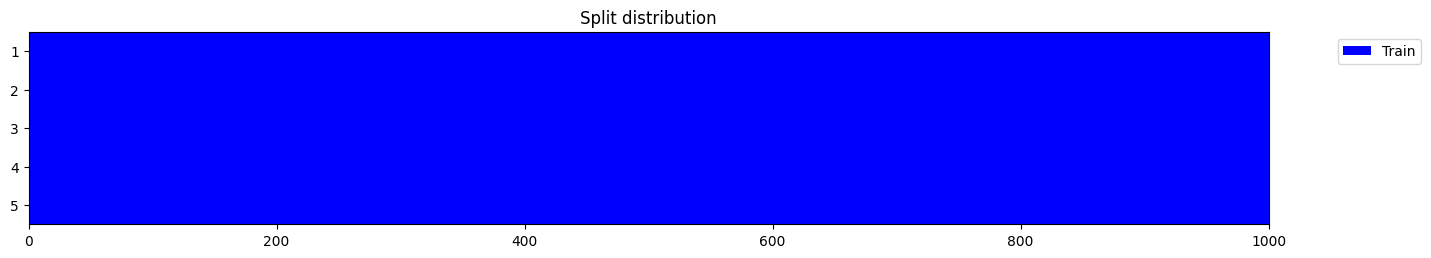

In [ ]:
n_splits = 5
valid_size = 0.
test_size = 0.
shuffle = True
stratify = True
train_only = True
train_size = None
check_splits = True
random_state = 1
show_plot = True 

splits = get_splits(y, n_splits=n_splits, valid_size=valid_size, test_size=test_size, shuffle=shuffle, stratify=stratify,
                    train_only=train_only, train_size=train_size, check_splits=check_splits, random_state=random_state, show_plot=show_plot, verbose=True)
for split in splits: 
    test_eq(len(split[0]), len(y))
    test_eq(np.sort(split[0]), np.arange(len(y)))

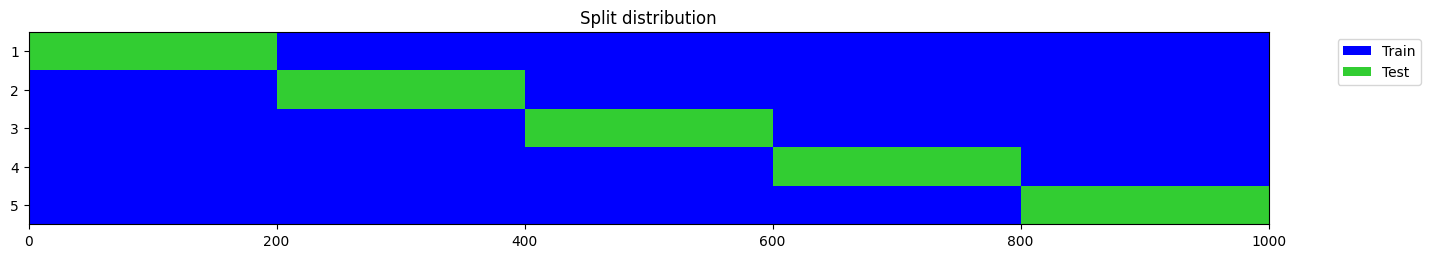

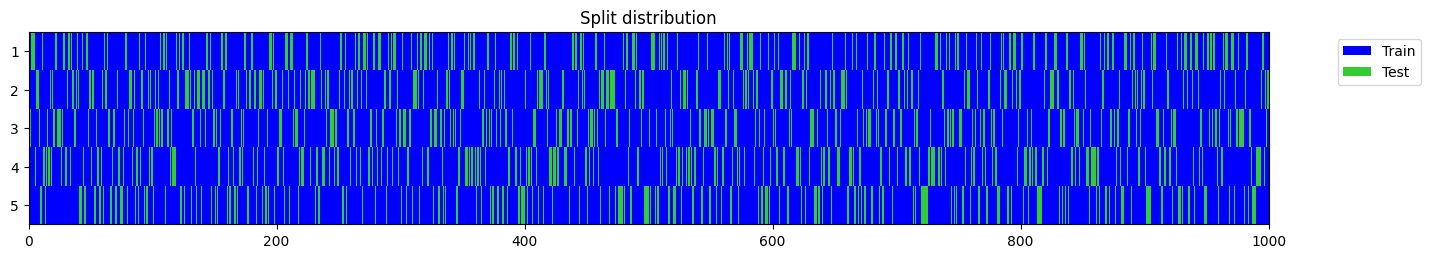

In [ ]:
n_splits = 5
y = np.random.randint(0, 2, 1000)

splits = get_splits(y, n_splits=n_splits, shuffle=False, check_splits=True)
test_eq(np.concatenate((L(zip(*splits))[1])), np.arange(len(y)))

splits = get_splits(y, n_splits=n_splits, shuffle=True, check_splits=True)
test_eq(np.sort(np.concatenate((L(zip(*splits))[1]))), np.arange(len(y)))

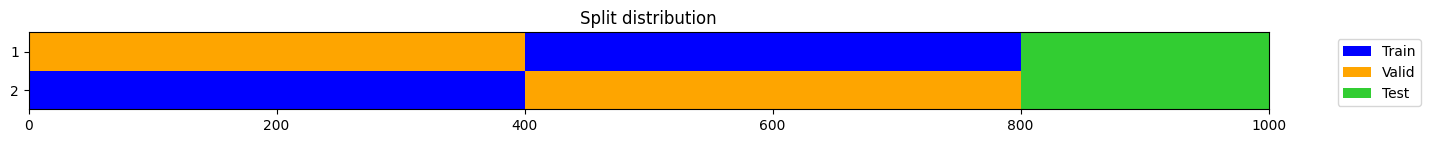

In [ ]:
n_splits = 2
y = np.random.randint(0, 2, 1000)

splits = get_splits(y, n_splits=n_splits, test_size=0.2, shuffle=False)
for i in range(n_splits): leakage_finder(*splits[i])
test_eq(len(splits), n_splits)
test_eq(len(splits[0]), 3)
s = []
[s.extend(split) for split in splits[0]]
test_eq(np.sort(s), np.arange(len(y)))
s = []
[s.extend(split) for split in splits[1]]
test_eq(np.sort(s), np.arange(len(y)))

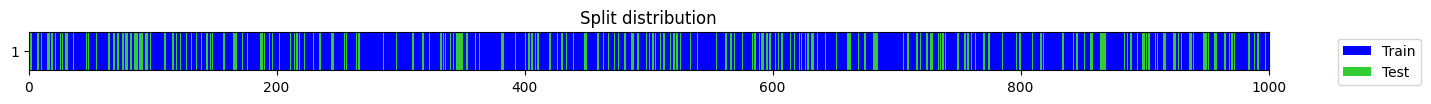

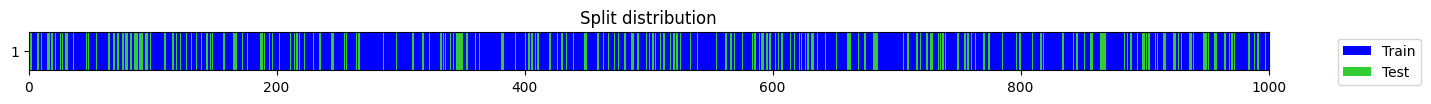

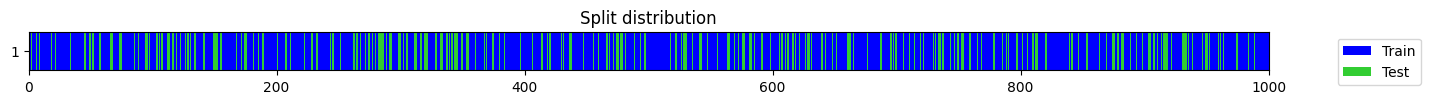

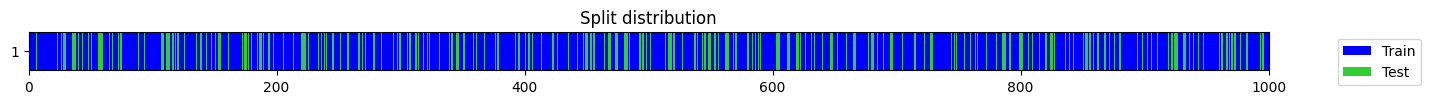

In [ ]:
y = np.random.randint(0, 2, 1000)
splits1 = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
splits2 = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
splits3 = get_splits(y, valid_size=.25, test_size=0, random_state=None, stratify=True, shuffle=True)
splits4 = get_splits(y, valid_size=.25, test_size=0, random_state=None, stratify=True, shuffle=True)
test_eq(splits1[0], splits2[0])
test_ne(splits3[0], splits4[0])

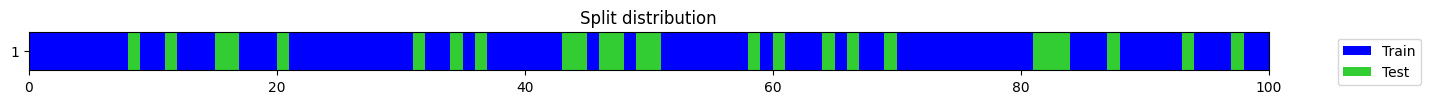

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True, shuffle=True)
test_eq(len(splits), 2)

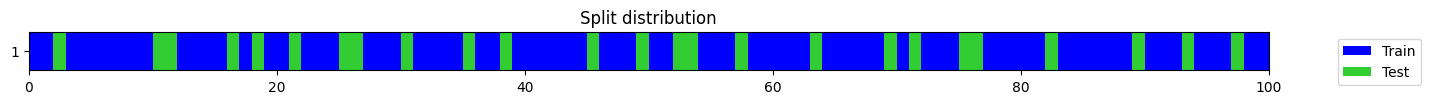

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=0, random_state=23, stratify=True)
test_eq(len(splits), 2)

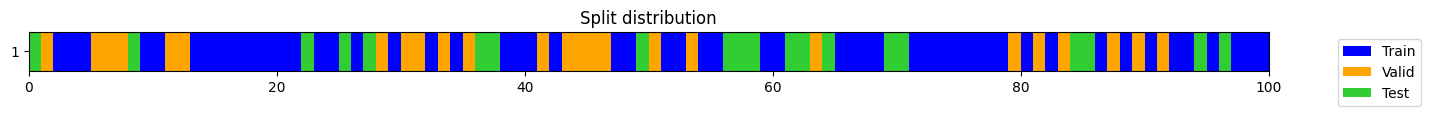

In [ ]:
y = np.random.randint(0, 2, 100)
splits = get_splits(y, valid_size=.25, test_size=20, random_state=23, stratify=True)
test_eq(len(splits), 3)
leakage_finder(*splits)

In [ ]:
splits = TrainValidTestSplitter(valid_size=.25, test_size=20, random_state=23, stratify=True)(np.random.randint(0, 2, 100))
test_eq(len(splits[1]), 25)
test_eq(len(splits[2]), 20)

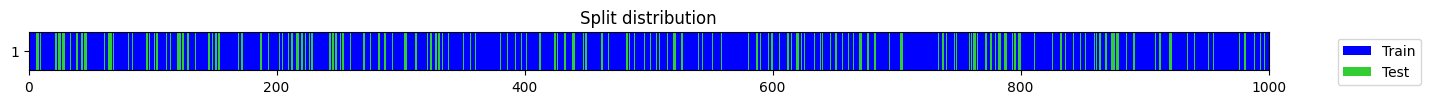

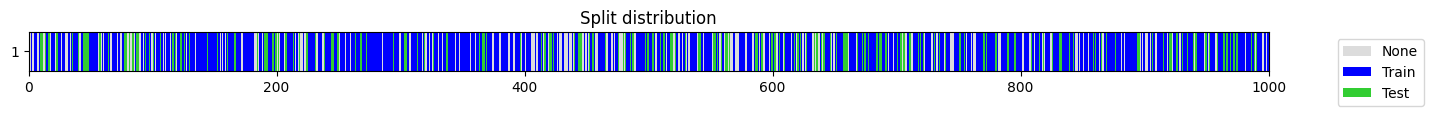

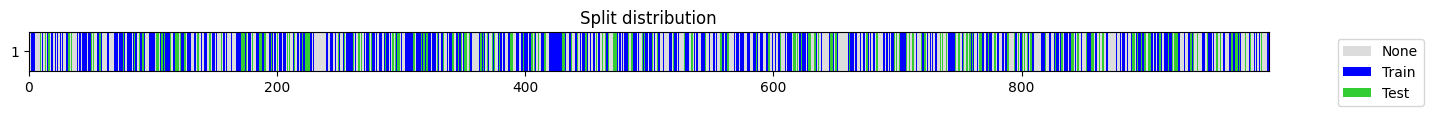

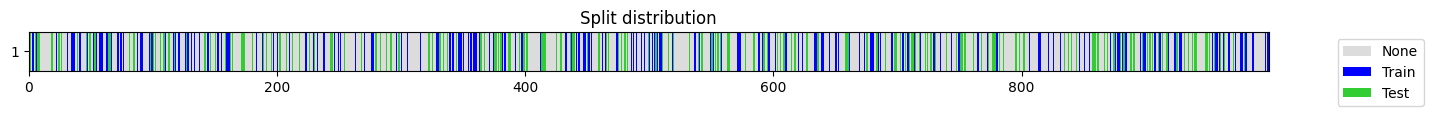

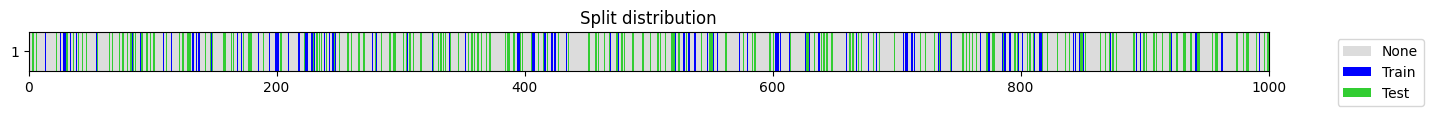

In [ ]:
o = np.random.randint(0, 2, 1000)
for p in [1, .75, .5, .25, .125]:
    splits = get_splits(o, train_size=p)
    test_eq(len(splits[0]), len(o) * .8 * p)

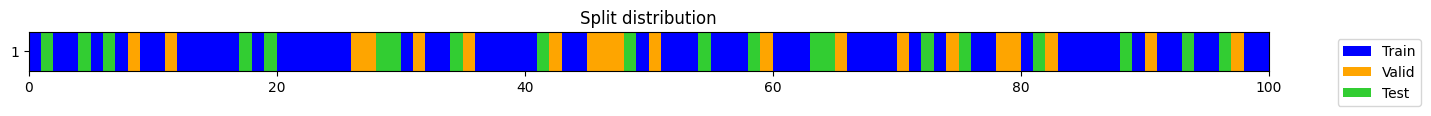

((#60) [49,87,71,98,84,36,66,57,24,30...],
 (#20) [46,79,45,78,42,65,35,97,11,50...],
 (#20) [63,48,6,88,4,81,1,58,64,28...])

In [ ]:
y = L([0] * 50 + [1] * 25 + [2] * 15 + [3] * 10)
splits = get_splits(y, valid_size=.2, test_size=.2)
test_eq(np.mean(y[splits[0]])==np.mean(y[splits[1]])==np.mean(y[splits[2]]), True)
splits

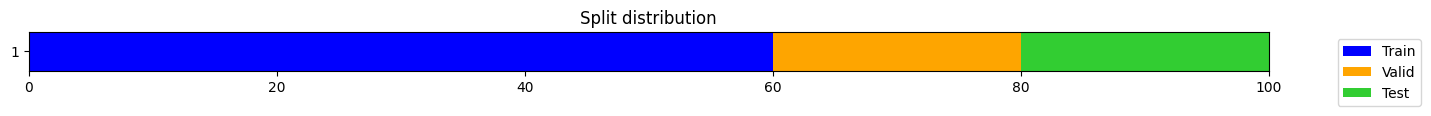

((#60) [0,1,2,3,4,5,6,7,8,9...],
 (#20) [60,61,62,63,64,65,66,67,68,69...],
 (#20) [80,81,82,83,84,85,86,87,88,89...])

In [ ]:
y = L([0] * 50 + [1] * 25 + [2] * 15 + [3] * 10)
splits = get_splits(y, n_splits=1, valid_size=.2, test_size=.2, shuffle=False)
# test_eq(splits[0] + splits[1] + splits[2], np.arange(100))
splits

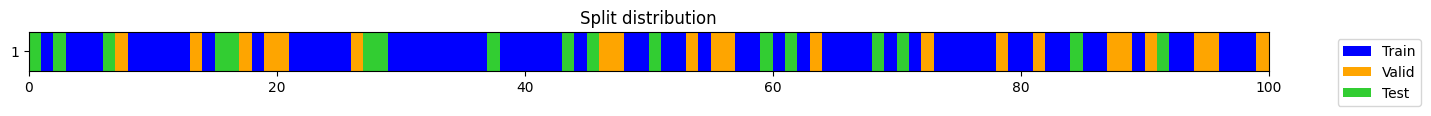

In [ ]:
splits = get_splits(np.random.randint(0,5,100), valid_size=0.213, test_size=17)
test_eq(len(splits[1]), 21)
test_eq(len(splits[2]), 17)

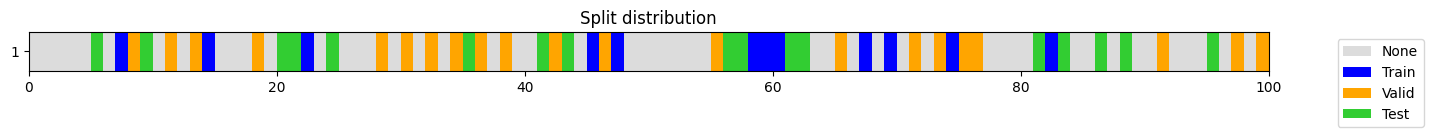

((#12) [58,22,7,60,82,14,67,69,59,47...],
 (#21) [18,34,46,65,8,30,55,42,97,71...],
 (#17) [41,57,43,95,86,88,35,24,5,81...])

In [ ]:
splits = get_splits(np.random.randint(0,5,100), valid_size=0.213, test_size=17, train_size=.2)
splits

In [ ]:
#|export
def get_predefined_splits(*xs):
    '''xs is a list with X_train, X_valid, ...'''
    splits_ = []
    start = 0
    for x in xs: 
        splits_.append(L(list(np.arange(start, start + len(x)))))
        start += len(x)
    return tuple(splits_)

def combine_split_data(xs, ys=None):
    '''xs is a list with X_train, X_valid, .... ys is None or a list with y_train, y_valid, .... '''
    xs = [to3d(x) for x in xs]
    splits = get_predefined_splits(*xs)
    if ys is None: return concat(*xs), None, splits
    else: return concat(*xs), concat(*ys), splits

In [ ]:
#|export
def get_splits_len(splits):
    _len = []
    for split in splits: 
        if isinstance(split[0], (list, L, tuple)):  _len.append([len(s) for s in split])
        else: _len.append(len(split))
    return _len

In [ ]:
X_train, y_train, X_valid, y_valid = np.random.rand(3,3,4), np.random.randint(0,2,3), np.random.rand(2,3,4), np.random.randint(0,2,2)
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
test_eq(X_train, X[splits[0]])
test_eq(X_valid, X[splits[1]])
test_type(X_train, X)
test_type(y_train, y)

In [ ]:
X_train, y_train, X_valid, y_valid = np.random.rand(3,4), np.random.randint(0,2,3), np.random.rand(2,4), np.random.randint(0,2,2)
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
test_eq(X_train[:, None], X[splits[0]])
test_eq(X_valid[:, None], X[splits[1]])
test_type(X_train, X)
test_type(y_train, y)

# Forecasting

In [ ]:
#|export
def get_usable_idxs(df, fcst_history, fcst_horizon, stride=1):
    if len(df) < fcst_history + fcst_horizon:
        return []
    usable_idxs = df[fcst_history - 1:len(df) - fcst_horizon].index.values
    if stride != 1:
        usable_idxs = usable_idxs[::-stride][::-1]
    return usable_idxs


def get_df_usable_idxs(
    df,                         # dataframe containing a sorted time series
    fcst_history,               # # historical steps used as input (size of the sliding window for the input)
    fcst_horizon,               # # steps forecasted into the future (size of the sliding window for the target)
    stride=1,                   # int or tuple of 2 int containing the strides of the sliding windows (input and target)
    unique_id_cols=None,        # str indicating the column/s with the unique identifier/s for each entity
):
    dtype = smallest_dtype(len(df))
    if unique_id_cols is not None:
        usable_df_idxs = np.sort(np.concatenate(df
                                                .reset_index(drop=True)
                                                .groupby(unique_id_cols)
                                                .apply(lambda x: get_usable_idxs(x, 
                                                                                 fcst_history=fcst_history, 
                                                                                 fcst_horizon=fcst_horizon, 
                                                                                 stride=stride
                                                                                )).values, dtype=dtype))
    else:
        usable_df_idxs = np.sort(get_usable_idxs(df, fcst_history, fcst_horizon, stride).astype(dtype=dtype))
    return usable_df_idxs

In [ ]:
#|export
def calculate_fcst_stats(
    df, # dataframe containing a sorted time series for a single entity or subject
    fcst_history, # # historical steps used as input.
    fcst_horizon, # # steps forecasted into the future. 
    splits, # splits that will be used to train the model. splits[0] is the train split:
    x_vars=None, # features used as input
    y_vars=None,  # features used as output
    subset_size=None, # int or float to determne the number of train samples used to calculate the mean and std
):
    "Calculates the training stats required in a forecasting task"
    x_vars = list(df.columns) if x_vars is None else feat2list(x_vars)
    y_vars = list(df.columns) if y_vars is None else feat2list(y_vars)
    split = splits[0] if is_listy(splits[0]) else splits
    if fcst_history == 1:
        train_idxs = split
    else:
        
        if subset_size is None:
            idxs = split
        else:
            subset = int(subset_size) if isinstance(subset_size, Integral) else int(subset_size * len(split))
            idxs = random_choice(idxs, subset, replace=False)
        dtype = smallest_dtype(max(split) + fcst_history)
        train_idxs = np.unique((np.asarray(idxs, dtype=dtype).reshape(-1,1) + np.arange(fcst_history, dtype=dtype).reshape(1, -1)).flatten())
    mean = df.reset_index().loc[train_idxs, x_vars].mean().values.reshape(1, -1, 1)
    std  = df.reset_index().loc[train_idxs, x_vars].std().values.reshape(1, -1, 1)
    if x_vars == y_vars:
        return (mean, std)
    y_mean = df.reset_index().loc[train_idxs, y_vars].mean().values.reshape(1, -1, 1)
    y_std  = df.reset_index().loc[train_idxs, y_vars].std().values.reshape(1, -1, 1)
    return (mean, std), (y_mean, y_std)

In [ ]:
#|export
def get_forecasting_splits(
    df,                         # dataframe containing a sorted time series
    fcst_history,               # # historical steps used as input (size of the sliding window for the input)
    fcst_horizon,               # # steps forecasted into the future (size of the sliding window for the target)
    stride=1,                   # int or tuple of 2 int containing the strides of the sliding windows (input and target)
    valid_size=0.,              # int or float indicating the size of the training set (based on datetimes)
    test_size=0.2,              # int or float indicating the size of the test set (based on datetimes)
    valid_cutoff_datetime=None, # first prediction datetime of validation dataset
    test_cutoff_datetime=None,  # first prediction datetime of test dataset
    datetime_col=None,          # str indicating the column with the datetime values
    use_index=False,            # flag to indicate if the datetime is in the index
    unique_id_cols=None,        # str indicating the column/s with the unique identifier/s for each entity
    show_plot=True,             # flag to indicate if splits should be plotted
):

    if unique_id_cols or valid_cutoff_datetime is not None or test_cutoff_datetime is not None:
        assert datetime_col is not None or use_index, \
        "you need to pass a datetime_col or set use_index=False to be able to access datetime"
    
    if valid_cutoff_datetime is not None or test_cutoff_datetime is not None:
        valid_size = 0
        test_size = 0
        
    use_valid = valid_cutoff_datetime is not None or valid_size != 0
    use_test = test_cutoff_datetime is not None or test_size != 0
    
    if valid_cutoff_datetime is not None: 
        valid_cutoff_datetime = np.datetime64(valid_cutoff_datetime)
    if test_cutoff_datetime is not None: 
        test_cutoff_datetime = np.datetime64(test_cutoff_datetime)

    if use_index:
        datetime_col = 'index' if df.index.name is None else df.index.name
        df = df.reset_index(drop=False)[feat2list(datetime_col) + feat2list(unique_id_cols)]
    elif datetime_col is not None:
        df = df[feat2list(datetime_col) + feat2list(unique_id_cols)]
    else:
        df = df.reset_index(drop=True)
        if unique_id_cols is not None: 
            df = df[feat2list(unique_id_cols)]
    
    usable_df_idxs = get_df_usable_idxs(df, fcst_history, fcst_horizon, stride=stride, unique_id_cols=unique_id_cols)
    usable_np_idxs = usable_df_idxs - (fcst_history - 1)

    if datetime_col is not None:
        usable_steps = pd.to_datetime(df.loc[usable_df_idxs, datetime_col])
        cat = usable_steps.astype('category').cat
        usable_step_codes = cat.codes.values
    else:
        usable_step_codes = np.arange(len(usable_df_idxs))
        

    # test indices
    if test_cutoff_datetime is not None:
        test_start = np.argmax(cat.categories >= test_cutoff_datetime)
        test_idxs = usable_np_idxs[usable_step_codes >= test_start]
    elif test_size:
        if test_size < 1:
            if unique_id_cols is None:
                n_usable_steps = len(usable_step_codes) - (fcst_horizon - 1) * (int(valid_size > 0) + int(test_size > 0))
            else:
                n_usable_steps = len(usable_step_codes)
            test_size = round(n_usable_steps * test_size)
        test_start = np.sort(usable_step_codes)[- test_size]
        test_idxs = usable_np_idxs[usable_step_codes >= test_start]
    else:
        test_idxs = np.array([])
    test_size = len(test_idxs)
    
    # valid indices
    if valid_cutoff_datetime is not None:
        valid_start =  np.argmax(cat.categories >= valid_cutoff_datetime)
        if test_cutoff_datetime is not None:
            valid_end = test_start - (fcst_horizon - 1) // stride
            assert valid_start <= valid_end, "you need to modify valid_size and/or test_size due to lack of data"
            valid_idxs = usable_np_idxs[(usable_step_codes >= valid_start) & (usable_step_codes < valid_end)]
        else:
            valid_idxs = usable_np_idxs[(usable_step_codes >= valid_start)]
    elif valid_size:
        if valid_size < 1:
            if unique_id_cols is None:
                n_usable_steps = len(usable_step_codes) - (fcst_horizon - 1) * (int(valid_size > 0) + int(test_size > 0))
            else:
                n_usable_steps = len(usable_step_codes)
            valid_size = round(n_usable_steps * valid_size)
        if test_size:
            valid_end = test_start - (fcst_horizon - 1) // stride
            remaining_usable_step_codes = usable_step_codes[usable_step_codes < valid_end]
            valid_start = np.sort(remaining_usable_step_codes)[- valid_size]
            assert 0 < valid_start <= valid_end <= test_start, "you need to modify valid_size and/or test_size due to lack of data"
            valid_idxs = usable_np_idxs[(usable_step_codes >= valid_start) & (usable_step_codes < valid_end)]
        else:
            valid_start = np.sort(usable_step_codes)[- valid_size]
            valid_idxs = usable_np_idxs[usable_step_codes >= valid_start]
    else:
        valid_idxs = np.array([])
    valid_size = len(valid_idxs)

    # train indices
    if use_valid:
        train_end = valid_start - (fcst_horizon - 1) // stride
        assert train_end > 0, "you need to modify valid_size due to lack of data"
        train_idxs = usable_np_idxs[usable_step_codes < train_end]
    elif use_test:
        train_end = test_start - (fcst_horizon - 1) // stride
        assert train_end > 0, "you need to modify test_size due to lack of data"
        train_idxs = usable_np_idxs[usable_step_codes < train_end]
    else:
        train_idxs = usable_np_idxs
    train_size = len(train_idxs)

    
    if len(df) < 1_000_000:
        train_idxs = L(train_idxs.tolist())
        if len(valid_idxs):
            valid_idxs = L(valid_idxs.tolist())
        if len(test_idxs):
            test_idxs = L(test_idxs.tolist())

    splits = (train_idxs,)
    if valid_size:
        splits += (valid_idxs,)
    if test_size:
        splits += (test_idxs,)

    if show_plot:
        if len(df) > 1_000_000:
            warnings.warn('the splits are too large to be plotted')
        else:
            plot_splits(splits)
    return tuple(splits)

,value,datetime,type
0,0,1749-03-31,1
1,1,1749-04-01,1
2,2,1749-04-02,1
3,3,1749-04-03,1
4,4,1749-04-04,1
...,...,...,...
95,95,1749-07-04,1
96,96,1749-07-05,1
97,97,1749-07-06,1
98,98,1749-07-07,1


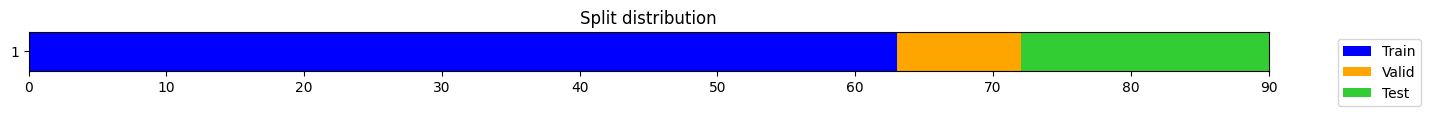

splits size   : [63, 9, 18] (90: [0.7, 0.1, 0.2])


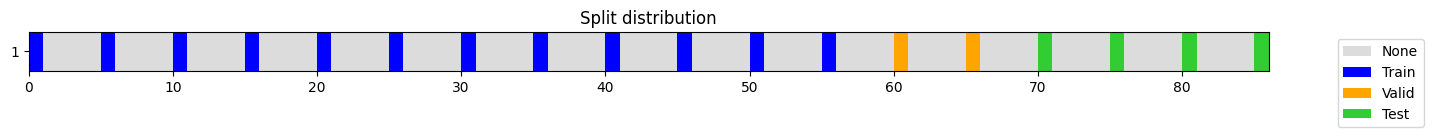

splits size   : [12, 2, 4] (18: [0.67, 0.11, 0.22])


In [ ]:
df1_len = 100
df2_len = 80

datetime_col = 'datetime' 
df1 = pd.DataFrame(np.arange(df1_len), columns=['value'])
df1['datetime'] = pd.date_range(pd.to_datetime('1749-03-31'), periods=df1_len, freq='1D')
df1['type'] = 1

df = df1
display(df)

# settings
fcst_history          = 10
fcst_horizon          = 1
stride                = 1
unique_id_cols        = 'type'
datetime_col          = 'datetime' 
use_index             = False
valid_size            = 0.1  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
test_size             = 0.2  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
valid_cutoff_datetime = '1749-08-21' # first prediction datetime of validation dataset
test_cutoff_datetime  = '1749-12-24' # first prediction datetime of test dataset
valid_cutoff_datetime = None # datetime compatible with the datetime_col containing the starting date for the validation dataset
test_cutoff_datetime  = None # datetime compatible with the datetime_col containing the starting date for the validation dataset


splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, stride=stride, 
                                unique_id_cols=unique_id_cols, datetime_col=datetime_col, use_index=use_index,
                                valid_size=valid_size, test_size=test_size, 
                                valid_cutoff_datetime=valid_cutoff_datetime, test_cutoff_datetime=test_cutoff_datetime)

print(f"splits size   : {[len(s) for s in splits]} ({sum([len(s) for s in splits])}: {[round(len(s)/sum([len(s) for s in splits]), 2) for s in splits]})")

# settings
fcst_history          = 10
fcst_horizon          = 5
stride                = 5
unique_id_cols        = 'type'
datetime_col          = 'datetime' 
use_index             = False
valid_size            = 0.1  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
test_size             = 0.2  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
valid_cutoff_datetime = '1749-08-21' # first prediction datetime of validation dataset
test_cutoff_datetime  = '1749-12-24' # first prediction datetime of test dataset
valid_cutoff_datetime = None # datetime compatible with the datetime_col containing the starting date for the validation dataset
test_cutoff_datetime  = None # datetime compatible with the datetime_col containing the starting date for the validation dataset


splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, stride=stride, 
                                unique_id_cols=unique_id_cols, datetime_col=datetime_col, use_index=use_index,
                                valid_size=valid_size, test_size=test_size, 
                                valid_cutoff_datetime=valid_cutoff_datetime, test_cutoff_datetime=test_cutoff_datetime)

print(f"splits size   : {[len(s) for s in splits]} ({sum([len(s) for s in splits])}: {[round(len(s)/sum([len(s) for s in splits]), 2) for s in splits]})")

,value,type
datetime,,
1749-03-31,0,1
1749-04-01,1,1
1749-04-02,2,1
1749-04-03,3,1
1749-04-04,4,1
...,...,...
1749-07-04,95,1
1749-07-05,96,1
1749-07-06,97,1


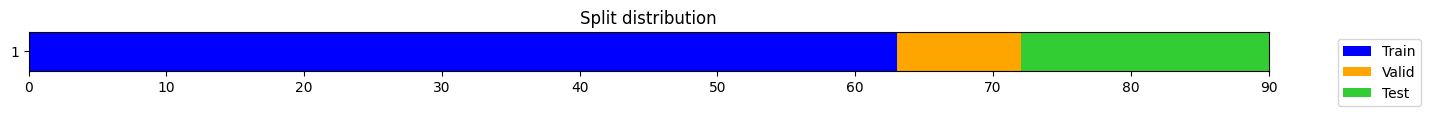

splits size   : [63, 9, 18] (90: [0.7, 0.1, 0.2])


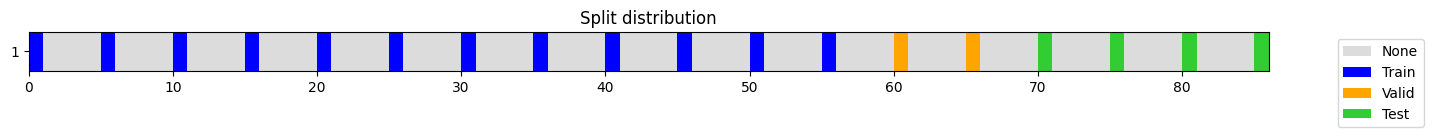

splits size   : [12, 2, 4] (18: [0.67, 0.11, 0.22])


In [ ]:
df1_len = 100
df2_len = 80

datetime_col = 'datetime' 
df1 = pd.DataFrame(np.arange(df1_len), columns=['value'])
df1['datetime'] = pd.date_range(pd.to_datetime('1749-03-31'), periods=df1_len, freq='1D')
df1['type'] = 1
df1_index = df1.set_index("datetime")

df = df1_index
display(df)

# settings
fcst_history          = 10
fcst_horizon          = 1
stride                = 1
unique_id_cols        = 'type'
datetime_col          = 'datetime' 
use_index             = True
valid_size            = 0.1  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
test_size             = 0.2  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
valid_cutoff_datetime = '1749-08-21' # first prediction datetime of validation dataset
test_cutoff_datetime  = '1749-12-24' # first prediction datetime of test dataset
valid_cutoff_datetime = None # datetime compatible with the datetime_col containing the starting date for the validation dataset
test_cutoff_datetime  = None # datetime compatible with the datetime_col containing the starting date for the validation dataset


splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, stride=stride, 
                                unique_id_cols=unique_id_cols, datetime_col=datetime_col, use_index=use_index,
                                valid_size=valid_size, test_size=test_size, 
                                valid_cutoff_datetime=valid_cutoff_datetime, test_cutoff_datetime=test_cutoff_datetime)

print(f"splits size   : {[len(s) for s in splits]} ({sum([len(s) for s in splits])}: {[round(len(s)/sum([len(s) for s in splits]), 2) for s in splits]})")

# settings
fcst_history          = 10
fcst_horizon          = 5
stride                = 5
unique_id_cols        = 'type'
datetime_col          = 'datetime' 
use_index             = True
valid_size            = 0.1  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
test_size             = 0.2  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
valid_cutoff_datetime = '1749-08-21' # first prediction datetime of validation dataset
test_cutoff_datetime  = '1749-12-24' # first prediction datetime of test dataset
valid_cutoff_datetime = None # datetime compatible with the datetime_col containing the starting date for the validation dataset
test_cutoff_datetime  = None # datetime compatible with the datetime_col containing the starting date for the validation dataset


splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, stride=stride, 
                                unique_id_cols=unique_id_cols, datetime_col=datetime_col, use_index=use_index,
                                valid_size=valid_size, test_size=test_size, 
                                valid_cutoff_datetime=valid_cutoff_datetime, test_cutoff_datetime=test_cutoff_datetime)

print(f"splits size   : {[len(s) for s in splits]} ({sum([len(s) for s in splits])}: {[round(len(s)/sum([len(s) for s in splits]), 2) for s in splits]})")

,value,datetime,type
0,0,1749-03-31,1
1,1,1749-04-01,1
2,2,1749-04-02,1
3,3,1749-04-03,1
4,4,1749-04-04,1
...,...,...,...
175,750,1749-06-29,2
176,760,1749-06-30,2
177,770,1749-07-01,2
178,780,1749-07-02,2


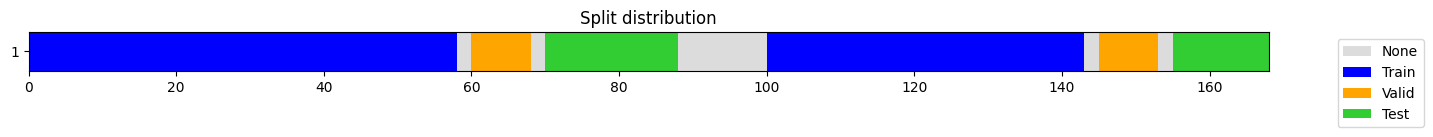

splits size   : [101, 16, 31] (148: [0.68, 0.11, 0.21])


In [ ]:
df1_len = 100
df2_len = 80

datetime_col = 'datetime' 
df1 = pd.DataFrame(np.arange(df1_len), columns=['value'])
df1['datetime'] = pd.date_range(pd.to_datetime('1749-03-31'), periods=df1_len, freq='1D')
df1['type'] = 1
df1_index = df1.set_index("datetime")
df2 = pd.DataFrame(np.arange(df2_len) * 10, columns=['value'])
df2['datetime'] = pd.date_range(pd.to_datetime('1749-04-15'), periods=df2_len, freq='1D')
df2['type'] = 2
df_comb = pd.concat([df1, df2]).reset_index(drop=True).reset_index(drop=True)


df = df_comb
display(df)

# settings
fcst_history          = 10
fcst_horizon          = 3
stride                = 1
unique_id_cols        = 'type'
datetime_col          = 'datetime' 
use_index             = False
valid_size            = 0.1  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
test_size             = 0.2  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
valid_cutoff_datetime = '1749-08-21' # first prediction datetime of validation dataset
test_cutoff_datetime  = '1749-12-24' # first prediction datetime of test dataset
valid_cutoff_datetime = None # datetime compatible with the datetime_col containing the starting date for the validation dataset
test_cutoff_datetime  = None # datetime compatible with the datetime_col containing the starting date for the validation dataset


splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, stride=stride, 
                                unique_id_cols=unique_id_cols, datetime_col=datetime_col, use_index=use_index,
                                valid_size=valid_size, test_size=test_size, 
                                valid_cutoff_datetime=valid_cutoff_datetime, test_cutoff_datetime=test_cutoff_datetime)

print(f"splits size   : {[len(s) for s in splits]} ({sum([len(s) for s in splits])}: {[round(len(s)/sum([len(s) for s in splits]), 2) for s in splits]})")

,value,type
1749-03-31,0,1
1749-04-01,1,1
1749-04-02,2,1
1749-04-03,3,1
1749-04-04,4,1
...,...,...
1749-06-29,750,2
1749-06-30,760,2
1749-07-01,770,2
1749-07-02,780,2


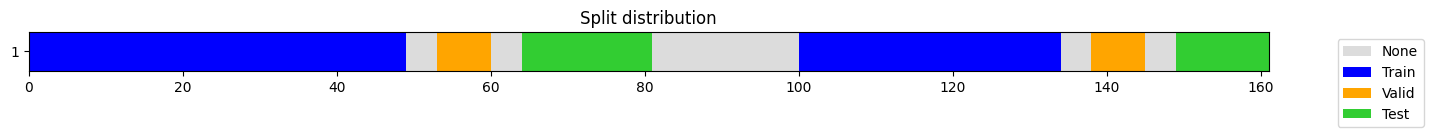

splits size   : [83, 14, 29] (126: [0.66, 0.11, 0.23])


In [ ]:
df1_len = 100
df2_len = 80

datetime_col = 'datetime' 
df1 = pd.DataFrame(np.arange(df1_len), columns=['value'])
df1['datetime'] = pd.date_range(pd.to_datetime('1749-03-31'), periods=df1_len, freq='1D')
df1['type'] = 1
df1_index = df1.set_index("datetime")
df2 = pd.DataFrame(np.arange(df2_len) * 10, columns=['value'])
df2['datetime'] = pd.date_range(pd.to_datetime('1749-04-15'), periods=df2_len, freq='1D')
df2['type'] = 2
df_comb = pd.concat([df1, df2]).reset_index(drop=True).reset_index(drop=True)
df_comb_index = df_comb.set_index("datetime")
df_comb_index.index.name = None


df = df_comb_index
display(df)

# settings
fcst_history          = 15
fcst_horizon          = 5
stride                = 1
unique_id_cols        = 'type'
datetime_col          = 'datetime' 
use_index             = True
valid_size            = 0.1  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
test_size             = 0.2  # a percent (float) or a number of samples (int) - .1 means 10% of the dates
valid_cutoff_datetime = '1749-08-21' # first prediction datetime of validation dataset
test_cutoff_datetime  = '1749-12-24' # first prediction datetime of test dataset
valid_cutoff_datetime = None # datetime compatible with the datetime_col containing the starting date for the validation dataset
test_cutoff_datetime  = None # datetime compatible with the datetime_col containing the starting date for the validation dataset


splits = get_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, stride=stride, 
                                unique_id_cols=unique_id_cols, datetime_col=datetime_col, use_index=use_index,
                                valid_size=valid_size, test_size=test_size, 
                                valid_cutoff_datetime=valid_cutoff_datetime, test_cutoff_datetime=test_cutoff_datetime)

print(f"splits size   : {[len(s) for s in splits]} ({sum([len(s) for s in splits])}: {[round(len(s)/sum([len(s) for s in splits]), 2) for s in splits]})")

In [ ]:
#|export
def get_long_term_forecasting_splits(
    df, # dataframe containing a sorted time series for a single entity or subject
    fcst_history,   # # historical steps used as input.
    fcst_horizon,   # # steps forecasted into the future. 
    dsid=None,      # dataset name
    show_plot=True, # plot the splits
):
    "Returns the train, valid and test splits for long-range time series datasets"
    
    if dsid in ["ETTh1", "ETTh2"]:
        border1s = [0, 12 * 30 * 24 - fcst_history, 12 * 30 * 24 + 4 * 30 * 24 - fcst_history]
        border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]
    elif dsid in ["ETTm1", "ETTm2"]:
        border1s = [0, 12 * 30 * 24 * 4 - fcst_history, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4 - fcst_history]
        border2s = [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 8 * 30 * 24 * 4]
    else:
        train_size = .7 # default 0.7
        test_size = .2 # default 0.2        
        num_train = int(len(df) * train_size)
        num_test = int(len(df) * test_size)
        num_vali = len(df) - num_train - num_test
        assert num_train + num_test + num_vali <= len(df)
        border1s = [0, num_train - fcst_history, len(df) - num_test - fcst_history]
        border2s = [num_train, num_train + num_vali, len(df)]

    train_split = L(np.arange(border1s[0], border2s[0] - fcst_horizon - fcst_history + 1).tolist())
    valid_split = L(np.arange(border1s[1], border2s[1] - fcst_horizon - fcst_history + 1).tolist())
    test_split = L(np.arange(border1s[2], border2s[2] - fcst_horizon - fcst_history + 1).tolist())   
    splits = train_split, valid_split, test_split
    if show_plot:
        plot_splits(splits)
    return splits

In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/003_data.validation.ipynb saved at 2023-03-14 19:31:42
Correct notebook to script conversion! 😃
Tuesday 14/03/23 19:31:45 CET
